In [634]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import Dataset, DataLoader
from skimage import measure #supports video also
from torchvision.transforms import functional as FF
import pickle
import scipy.ndimage as ndimage
import seaborn as sns
import pandas as pd
import imagehash
import math as m
from scipy.spatial import distance
import time

In [692]:
channels=1

In [693]:
"""
Saving and loading of figures, network state and other .pickle objects
"""
def save_network(obj, filename):
    network_dict = obj.cpu().state_dict()
    ## Add if torch.cuda.is_available():
    obj.to(device)
    save(obj=network_dict, filename=filename)

def save(obj, filename):
    filename += ".pickle" if ".pickle" not in filename else ""
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    filename += ".pickle" if ".pickle" not in filename else ""
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

def figure_save(destination, obj=None):
    plt.savefig(destination)
    plt.savefig(destination + ".svg", format="svg")
    save(obj, destination) if obj else None
    
def make_folder_results(folder_name):
    if os.path.isdir(folder_name):
        imgs = os.listdir(folder_name)
        for img in imgs:
            os.remove(folder_name + "/" + img)
    else:
        os.mkdir(folder_name)

In [694]:
def imshow(inp, title=None, smoothen=False, return_np=False, obj=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    if smoothen:
        inp = ndimage.gaussian_filter(inp, sigma=(.5, .5, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if obj is not None:
        obj.imshow(inp)
        obj.axis("off")
        if title is not None:
            obj.set_title(title)
    else:
        plt.imshow(inp)
        plt.axis("off")
        if title is not None:
            plt.title(title)
    if return_np:
        return inp

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transformVar = {"Test": transforms.Compose([
    transforms.Resize(128),    #Already 184 x 184
    transforms.CenterCrop(128),
    transforms.ToTensor(),
#     normalize
]),
    "Train": transforms.Compose([
    transforms.Resize(128),  # Already 184 x 184
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
#     normalize
    ])
}


In [695]:
class Get_Data(Dataset):
    """
    Creates a data-loader.
    """
    def __init__(self, root_directory, transform=None, check_bad_data=True, channels=3):
        if isinstance(root_directory, str):
            self.root_dir = root_directory
            self.classes = listdir(root_directory)
            self.All_Imagesets = []
            for cla in self.classes:
                im_list = sorted(listdir(root_directory + cla))
                if not check_bad_data:
                    self.All_Imagesets.append((im_list, cla))
                else:
                    Good = True
                    for im in im_list:
                        Good = Good and self.filter_bad_data(root_directory + cla + "/" + im)
                    if Good:
                        self.All_Imagesets.append((im_list, cla))

        elif isinstance(root_directory, list):
            self.root_dir = root_directory[0]
            self.classes = root_directory[1]
            self.All_Imagesets = root_directory[2]

        self.transform = transform
        self.channels=channels


    def __len__(self):
        return len(self.All_Imagesets)

    def __getitem__(self, idx):
#         print('Get item')
        img_path = self.All_Imagesets[idx][1]
        im_list = sorted(listdir(self.root_dir + img_path))

        Concat_Img = self.concatenate_data(img_path, im_list)

        sample = {"image": Concat_Img,
                  "target": torch.LongTensor([self.classes.index(str(img_path))])}
        return sample

    def filter_bad_data(self, img_path):
        img = Image.open(img_path)
        return False if np.shape(img)[-1] != 3 else True

    def concatenate_data(self, img_path, im_list):
        """
        Concatenated image tensor with all images having the same random transforms applied
        """
        for i, image in enumerate(im_list):
            if self.channels == 1:
                img = Image.open(self.root_dir + img_path + "/" + image).convert('L')
            elif self.channels == 3:
                img = Image.open(self.root_dir + img_path + "/" + image)
            if i == 0:
                if self.transform:
                    for t in self.transform.transforms:
                        if "RandomResizedCrop" in str(t):
                            ii, j, h, w = t.get_params(img, t.scale, t.ratio)
                            img = FF.resized_crop(img, ii, j, h, w, t.size, t.interpolation)
                        elif "RandomHorizontalFlip" in str(t):
                            Horizontal_Flip = random.choice([True, False])
                            if Horizontal_Flip:
                                img = FF.hflip(img)
                        elif "RandomVerticalFlip" in str(t):
                            Vertical_Flip = random.choice([True, False])
                            if Vertical_Flip:
                                img = FF.vflip(img)
                        else:
                            img = t(img)
                Concat_Img = img
            else:
                if self.transform:
                    for t in self.transform.transforms:
                        if "RandomResizedCrop" in str(t):
                            img = FF.resized_crop(img, ii, j, h, w, t.size, t.interpolation)
                        elif "RandomHorizontalFlip" in str(t):
                            if Horizontal_Flip:
                                img = FF.hflip(img)
                        elif "RandomVerticalFlip" in str(t):
                            if Vertical_Flip:
                                img = FF.vflip(img)
                        else:
                            img = t(img)
                Concat_Img = torch.cat((Concat_Img, img), dim=0)
        return Concat_Img


def Create_Training_Testing_Datasets(root_directory, transform=None, test_fraction=0., validation_fraction=0., check_bad_data=True, channels=3):
    """
    Splits data into fractional parts (data does not overlap!!) and creates data-loaders for each fraction.
    :param root_directory: Directory of data
    :param transform: transforms to apply for each data set. Must contain "Train" and "Test" dict
    :param test_fraction: Fraction of data to go to test-set
    :param validation_fraction: Fraction of data to go to validation-set
    :param check_bad_data: Option to evaluate and filter out corrupted data/images
    :return:
    """
    def filter_bad_data(img_path):
        img = Image.open(img_path)
        return False if np.shape(img)[-1] != 3 else True

    print('Create datasets')
    if (test_fraction > 0) or (validation_fraction > 0):
        classes = listdir(root_directory)
        All_Imagesets = []
        for cla in classes:
            im_list = sorted(listdir(root_directory + cla))
            if not check_bad_data:
                All_Imagesets.append((im_list, cla))
            else:
                Good = True
                for im in im_list:
                    Good = Good and filter_bad_data(root_directory + cla + "/" + im)
                if Good:
                    All_Imagesets.append((im_list, cla))

        full_size = len(All_Imagesets)
        if test_fraction > 0:
            test = random.sample(All_Imagesets, int(full_size * test_fraction)) # All images i list of t0s
            for item in test:
                All_Imagesets.remove(item)

            Send = [root_directory, classes, test]
            Test = Get_Data(Send, transform["Test"], channels=channels)
#             yield Test

        if validation_fraction > 0:
            validate = random.sample(All_Imagesets, int(full_size * validation_fraction))  # All images i list of t0s
            for item in validate:
                All_Imagesets.remove(item)

            Send = [root_directory, classes, validate]
            Validate = Get_Data(Send, transform["Test"], channels=channels)
#             yield Validate

        Send = [root_directory, classes, All_Imagesets]
        Train = Get_Data(Send, transform["Train"], channels=channels)
#         yield Train
        return Test, Validate, Train
    else:
        Data = Get_Data(root_directory, transform, check_bad_data=check_bad_data, channels=channels)
        return Data


In [696]:
!rm -rf Results/
!rm Video_Data/.DS_Store

rm: Video_Data/.DS_Store: No such file or directory


In [697]:
nr_net = 0 

version = nr_net + 10
input_frames = 5
output_frames = 10
Type_Network = "7_kernel_3LSTM"
DataGroup = "LSTM"


# Little trick to adjust path files for compatibility (I have a backup of the Main.py in case it doesn't work)
# stef_path = "/media/sg6513/DATADRIVE2/MSc/Wavebox/"
# if os.path.isfile(stef_path + "stefpc.txt"):
#     if not os.path.isdir(stef_path + "Results"):
#         os.mkdir(stef_path + "Results")
#     maindir1 = stef_path + "Results/Simulation_Result_" + Type_Network + "_v%03d/" % version
#     maindir2 = stef_path
#     version += 200
# else:
if not os.path.isdir("./Results"):
    os.mkdir("./Results")
# maindir1 = "/mnt/Linux-HDD/Discrete_Data-sharing_LSTMs/Results/Simulation_Result_"\
maindir1 = "./Results/Simulation_Result_"\
           + Type_Network + "_v%03d/" % version

if not os.path.isdir(maindir1):
    make_folder_results(maindir1)

# Data
if os.path.isfile(maindir1 + "All_Data_" + DataGroup + "_v%03d.pickle" % version):
    My_Data = load(maindir1 + "All_Data_" + DataGroup + "_v%03d" % version)
    My_Train = My_Data["Training data"]
    My_Validate = My_Data["Validation data"]
    My_Test = My_Data["Testing data"]
else:
    My_Test, My_Validate, My_Train = Create_Training_Testing_Datasets(
         "./Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    My_Data = {"Training data": My_Train, "Validation data": My_Validate, "Testing data": My_Test}
    save(My_Data, maindir1 + "All_Data_" + DataGroup + "_v%03d" % version)

Create datasets


In [698]:
Train_Data = DataLoader(My_Train, batch_size=16, shuffle=True, num_workers=12)
Validate_Data = DataLoader(My_Validate, batch_size=16, shuffle=True, num_workers=12)
Test_Data = DataLoader(My_Test, batch_size=16, shuffle=True, num_workers=12)

In [699]:
imgs = My_Train[0]['image']

In [700]:
# i=0
# img = imgs[3*i:3*(i+1),:,:]
# imshow(img)

In [701]:
imgs.size()

torch.Size([100, 128, 128])

In [702]:
root_dir = My_Train.root_dir
img_path = My_Train.All_Imagesets[0]
im_list = sorted(listdir(root_dir + img_path[1]))

In [703]:
class Data_Analyser():
    """
    Saves network data for later analasys. Epochwise loss, Batchwise loss, Accuracy (not currently in use) and
    Validation loss
    """
    def __init__(self, maindir1):
        self.epoch_loss = []
        self.epoch_nr = []
        self.batch_loss = []
        self.batch_nr = []
        self.accuracy = []
        self.epoch_acc = []
        self.validation_loss = []
        self.validation_nr = []
        self.maindir1 = maindir1

    def save_loss(self, loss, epoch_increment=1):
        """
        Creates two lists, one of losses and one of index of epoch
        """
        self.epoch_loss.append(loss)
        self.epoch_nr.append(self.epoch_nr[len(self.epoch_nr) - 1] + epoch_increment) if len(self.epoch_nr)\
            else self.epoch_nr.append(epoch_increment)

    def plot_loss(self):
        fig = plt.figure().add_axes()
        sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
        sns.set_context("talk")
        data = {}
        data.update({"Epoch": self.epoch_nr, "Loss": self.epoch_loss})
        sns.lineplot(x="Epoch", y="Loss",
                     data=pd.DataFrame.from_dict(data), ax=fig)
        figure_save(self.self.maindir1 + "Epoch_Loss" + Type_Network + "_Project_v%03d" % version, obj=fig)
        plt.show()

    def save_loss_batchwise(self, loss, batch_increment=1):
        """
        Creates two lists, one of losses and one of index of batch
        """
        self.batch_loss.append(loss)
        self.batch_nr.append(self.batch_nr[len(self.batch_nr) - 1] + batch_increment) if len(self.batch_nr)\
            else self.batch_nr.append(batch_increment)

    def plot_loss_batchwise(self):
        fig = plt.figure().add_axes()
        sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
        sns.set_context("talk")
        data = {}
        data.update({"Batch": self.batch_nr, "Loss": self.batch_loss})
        sns.lineplot(x="Batch", y="Loss",
                     data=pd.DataFrame.from_dict(data), ax=fig)
        figure_save(self.self.maindir1 + "Batch_Loss" + Type_Network + "_Project_v%03d" % version, obj=fig)
        plt.show()

    def save_accuracy(self, accuracy, epoch_increment=1):
        """
        Creates two lists, one of accuracy and one of index of the accuracy (batchwise or epochwise)
        NOT IN USE
        """
        self.accuracy.append(accuracy)
        self.epoch_acc.append(self.epoch_acc[len(self.epoch_acc) - 1] + epoch_increment) if len(self.epoch_acc)\
            else self.epoch_acc.append(epoch_increment)

    def plot_accuracy(self):
        fig = plt.figure().add_axes()
        sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
        sns.set_context("talk")
        data = {}
        data.update({"Epoch": self.epoch_acc, "Accuracy": self.accuracy})
        sns.lineplot(x="Epoch", y="Accuracy",
                     data=pd.DataFrame.from_dict(data), ax=fig)
        figure_save(self.self.maindir1 + "Accuracy" + Type_Network + "_Project_v%03d" % version, obj=fig)
        plt.show()

    def save_validation_loss(self, loss, epoch_increment=1):
        """
        Creates two lists, one of validation losses and one of index of epoch
        """
        self.validation_loss.append(loss)
        self.validation_nr.append(self.validation_nr[len(self.validation_nr) - 1] + epoch_increment) if \
            len(self.validation_nr) else self.validation_nr.append(epoch_increment)

    def plot_validation_loss(self):
        """
        Plots validation and epoch loss next to each other
        """
        hue = []
        loss = []
        nr = []
        for i, element in enumerate(self.epoch_loss):
            loss.append(element)
            nr.append(self.epoch_nr[i])
            hue.append("Training Loss")
        for i, element in enumerate(self.validation_loss):
            loss.append(element)
            nr.append(self.validation_nr[i])
            hue.append("Validation Loss")
        fig = plt.figure().add_axes()
        sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
        sns.set_context("talk")
        data = {}
        data.update({"Epoch": nr, "Loss": loss, "hue": hue})
        sns.lineplot(x="Epoch", y="Loss", hue="hue",
                     data=pd.DataFrame.from_dict(data), ax=fig)
        figure_save(self.maindir1 + "Validation_Loss" + Type_Network + "_Project_v%03d" % version, obj=fig)
        plt.show()


In [704]:
# Analyser
if os.path.isfile(maindir1 + Type_Network + "_Analyser_v%03d.pickle" % version):
    Analyser = load(maindir1 + Type_Network + "_Analyser_v%03d" % version)
else:
    Analyser = Data_Analyser(maindir1)

In [705]:
class Network (nn.Module):
    """
    The network structure
    """
    def __init__(self, channels):
        super(Network, self).__init__()
        self.channels=channels
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(5*channels, 60, kernel_size=7, stride=2, padding=1),
            nn.BatchNorm2d(num_features=60),
            nn.Tanh(),
            nn.Conv2d(60, 120, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=120),
            nn.Tanh(),
            nn.Conv2d(120, 240, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=240),
            nn.Tanh(),
            nn.Conv2d(240, 480, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=480),
            nn.Tanh(),
            nn.Dropout2d(0.25)
        )

        self.encoder_linear = nn.Sequential(
            nn.Linear(30720, 1000),
            nn.Tanh(),
            nn.Dropout(0.25)
        )

        self.decoder_linear = nn.Sequential(
            nn.Tanh(),
            nn.Linear(1000, 30720)
        )

        self.decoder_conv = nn.Sequential(
            nn.Tanh(),
            nn.ConvTranspose2d(480, 240, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=240),
            nn.Tanh(),
            nn.ConvTranspose2d(240, 120, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=120),
            nn.Tanh(),
            nn.ConvTranspose2d(120, 60, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features=60),
            nn.Tanh(),
            nn.Dropout2d(0.25),
            nn.ConvTranspose2d(60, channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

        self.LSTM_0 = nn.LSTMCell(input_size=1000, hidden_size=1000, bias=True)

        self.LSTM = nn.LSTMCell(input_size=1000, hidden_size=1000, bias=True)

        self.LSTM_new_input = nn.LSTMCell(input_size=1000, hidden_size=1000, bias=True)


    def forward(self, x, mode="input", training=False): #"input", "new_input", "internal"
        x.requires_grad_(training)
        with torch.set_grad_enabled(training):
            if "input" in mode:
                x = self.encoder_conv(x)
                self.org_size = x.size()
                x = x.view(-1, 30720)
                x = self.encoder_linear(x)
                if mode == "input":
                    self.h0, self.c0 = self.LSTM_0(x, (self.h0, self.c0))
                elif mode == "new_input":
                    self.h0, self.c0 = self.LSTM_new_input(x, (self.h0, self.c0))
            elif mode == "internal":
                self.h0, self.c0 = self.LSTM(self.h0, (self.h0, self.c0))
            x = self.h0.clone()
            x = self.decoder_linear(x)
            x = x.view(self.org_size)
            x = self.decoder_conv(x)
            return x

    def reset_hidden(self, batch_size, training=False):
        self.h0 = torch.zeros((batch_size, 1000), requires_grad=training).to(device) #Requires grad replaces Variable
        self.c0 = torch.zeros((batch_size, 1000), requires_grad=training).to(device)


In [706]:
# Model
if os.path.isfile(maindir1 + Type_Network + "_Project_v%03d.pt" % version):
    model = torch.load(maindir1 + Type_Network + "_Project_v%03d.pt" % version)
else:
    model = Network(channels)


In [707]:
class Scorekeeper():
    """
    Calculates and keeps track of testing results
    SSIM/pHash/RMSE etc.
    """
    def __init__(self):
        super(Scorekeeper, self).__init__()

        self.intermitted = []
        self.frame = []
        self.hue = []

        self.pHash_val = []
        self.pHash_frame = []
        self.pHash_hue = []

        self.pHash2_val = []
        self.pHash2_frame = []
        self.pHash2_hue = []

        self.SSIM_val = []
        self.SSIM_frame = []
        self.SSIM_hue = []

        self.MSE_val = []
        self.MSE_frame = []
        self.MSE_hue = []

        self.own = False
        self.phash = False
        self.SSIM = False
        self.MSE = False

    def add(self, predicted, target, frame_nr, *args):
        predicted = self.normalize(predicted)
        target = self.normalize(target)

        if "Own"in args:
            spatial_score, scale_score = self.score(predicted, target)
            self.intermitted.append(spatial_score)
            self.frame.append(frame_nr)
            self.hue.append("Spatial")
            self.intermitted.append(scale_score)
            self.frame.append(frame_nr)
            self.hue.append("Scaling")
            self.own = True

        if "SSIM" in args:
            ssim_score = self.ssim(predicted, target)
            self.SSIM_val.append(ssim_score)
            self.SSIM_frame.append(frame_nr)
            self.SSIM_hue.append("SSIM")
            self.SSIM = True

        if "RMSE" in args:
            self.MSE_val.append(np.sqrt(measure.compare_mse(predicted, target)))
            self.MSE_frame.append(frame_nr)
            self.MSE_hue.append("RMSE")
            self.MSE = True

        if "pHash" in args:
            hamming = self.pHash(predicted, target, "hamming")
            self.pHash_val.append(hamming)
            self.pHash_frame.append(frame_nr)
            self.pHash_hue.append("pHash")
            self.phash = True

        if "pHash" in args:
            hamming = self.pHash(predicted, target, "jaccard")
            self.pHash2_val.append(hamming)
            self.pHash2_frame.append(frame_nr)
            self.pHash2_hue.append("pHash")
            self.phash2 = True

    def hamming2(self, s1, s2):
        """Calculate the Hamming distance between two bit strings"""
        assert len(s1) == len(s2)
        return sum(c1 != c2 for c1, c2 in zip(s1, s2))

    def pHash(self, predicted, target, *args):
        predicted = predicted * 255
        target = target * 255
        predicted = Image.fromarray(predicted.astype("uint8"))
        target = Image.fromarray(target.astype("uint8"))
        hash1 = hex_str2bool(str(imagehash.phash(predicted, hash_size=16)))
        hash2 = hex_str2bool(str(imagehash.phash(target, hash_size=16)))
        if "hamming" in args:
            return self.hamming2(hash1, hash2)
        elif "jaccard" in args:
            return distance.jaccard(hash1, hash2)
        else:
            return None
        # Out of 260

    def ssim(self, predicted, target):
        return measure.compare_ssim(predicted, target, multichannel=True, gaussian_weights=True)

    def normalize(self, image):
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        return np.clip(image, 0, 1)

    def score(self, predicted, target):
        predicted_mean = np.mean(predicted, axis=(0, 1))
        target_mean = np.mean(target, axis=(0, 1))
        pred_relative = np.abs(predicted - predicted_mean)
        target_relative = np.abs(target - target_mean)

        relative_diff = np.mean(np.abs(pred_relative - target_relative)) \
                        / (np.sum(target_relative) / np.prod(np.shape(target)))

        absolute_diff = np.mean(np.abs(predicted - target)) / (np.sum(target) / np.prod(np.shape(target)))

        return relative_diff, absolute_diff

    def plot(self):
        if self.own:
            all_data = {}
            all_data.update({"Time-steps Ahead": self.frame, "Difference": self.intermitted, "Scoring Type": self.hue})
            fig = plt.figure().add_axes()
            sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
            sns.lineplot(x="Time-steps Ahead", y="Difference", hue="Scoring Type",
                         data=pd.DataFrame.from_dict(all_data), ax=fig)
            figure_save(maindir1 + "Scoring_Quality", obj=fig)
            plt.show()

        if self.SSIM:
            all_data = {}
            all_data.update({"Time-steps Ahead": self.SSIM_frame, "Similarity": self.SSIM_val,
                                  "Scoring Type": self.SSIM_hue})
            fig = plt.figure().add_axes()
            sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
            sns.lineplot(x="Time-steps Ahead", y="Similarity", hue="Scoring Type",
                         data=pd.DataFrame.from_dict(all_data), ax=fig)
            plt.ylim(0, 1)
            figure_save(maindir1 + "SSIM_Quality", obj=fig)
            plt.show()

        if self.MSE:
            all_data = {}
            all_data.update({"Time-steps Ahead": self.MSE_frame, "Root Mean Square Error (L2 residual)": self.MSE_val,
                                 "Scoring Type": self.MSE_hue})
            fig = plt.figure().add_axes()
            sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
            sns.lineplot(x="Time-steps Ahead", y="Root Mean Square Error (L2 residual)", hue="Scoring Type",
                         data=pd.DataFrame.from_dict(all_data), ax=fig)
            figure_save(maindir1 + "RMSE_Quality", obj=fig)
            plt.show()

        if self.phash:
            all_data = {}
            all_data.update({"Time-steps Ahead": self.pHash_frame, "Hamming Distance": self.pHash_val,
                                   "Scoring Type": self.pHash_hue})
            fig = plt.figure().add_axes()
            sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
            sns.lineplot(x="Time-steps Ahead", y="Hamming Distance", hue="Scoring Type",
                         data=pd.DataFrame.from_dict(all_data), ax=fig)
            figure_save(maindir1 + "Scoring_Spatial_Hamming", obj=fig)
            plt.show()

        if self.phash2:
            all_data = {}
            all_data.update({"Time-steps Ahead": self.pHash2_frame, "Jaccard Distance": self.pHash2_val,
                                   "Scoring Type": self.pHash2_hue})
            fig = plt.figure().add_axes()
            sns.set(style="darkgrid")  # darkgrid, whitegrid, dark, white, and ticks
            sns.lineplot(x="Time-steps Ahead", y="Jaccard Distance", hue="Scoring Type",
                         data=pd.DataFrame.from_dict(all_data), ax=fig)
            figure_save(maindir1 + "Scoring_Spatial_Jaccard", obj=fig)
            plt.show()

In [708]:
# Learning Rate scheduler w. optimizer
if os.path.isfile(maindir1 + Type_Network + "_lrScheduler_v%03d.pickle" % version):
    scheduler_dict = load(maindir1 + Type_Network + "_lrScheduler_v%03d" % version)
    lrschedule = scheduler_dict["Type"]
    exp_lr_scheduler = scheduler_dict["Scheduler"]
else:
    # Optimizer
    optimizer_algorithm = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    # Add learning rate schedulers
    # Decay LR by a factor of gamma every step_size epochs
    lrschedule = 'plateau'
    if lrschedule == 'step':
        gamma = 0.5
        step_size = 40
        exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_algorithm, step_size=step_size, gamma=gamma)
    elif lrschedule == 'plateau':
        # Reduce learning rate when a metric has stopped improving
        exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_algorithm, mode='min', factor=0.1, patience=7)
        optimizer_algorithm = []
print('Optimizer created')

model.to(device)
score_keeper = Scorekeeper()

Optimizer created


In [709]:
import time
def train(epoch, DataLoader, Validate, plot=True, channels=3):
    """
    Training of the network
    :param epoch: Which epoch are you on
    :param DataLoader: Training data
    :param Validate: Validation data
    :return:
    """
    ### add grayscayle or rgb flag to gain speed
    def initial_input(training, channels):
        Data = ImageSeries[:, (t0 + n) * channels:(t0 + n + input_frames) * channels, :, :].to(device)
        output = model(Data, training=training)
        target = ImageSeries[:, (t0 + n + input_frames) * channels:(t0 + n + input_frames + 1) * channels, :, :].to(device)
        return output, target

    def new_input(output, target, training, channels):
        output = torch.cat((output, model(
            output[:, -input_frames * channels:, :, :].clone(), mode="new_input", training=training)
                            ), dim=1)
        target = torch.cat(
            (target, ImageSeries[:, (t0 + n + input_frames) * channels:(t0 + n + input_frames + 1) * channels, :, :].to(device)), dim=1
        )
        return output, target

    def consequent_propagation(output, target, training, channels):
        output = torch.cat((output, model(torch.Tensor([0]), mode="internal", training=training)), dim=1)
        target = torch.cat(
            (target, ImageSeries[:, (t0 + n + input_frames) * channels:(t0 + n + input_frames + 1) * channels, :, :].to(device)), dim=1
        )
        return output, target

    def plot_predictions():
        if (i == 0) & (batch_num == 0):
            predicted = output[i, -3:, :, :].cpu().detach()
            des_target = target[i, -3:, :, :].cpu().detach()
            fig = plt.figure()
            pred = fig.add_subplot(1, 2, 1)
            imshow(predicted, title="Predicted smoothened %02d" % n, smoothen=True, obj=pred)
            tar = fig.add_subplot(1, 2, 2)
            imshow(des_target, title="Target %02d" % n, obj=tar)
            plt.show()

    print('Training Epoch: %d' % epoch)
    model.train()           # initialises training stage/functions
    mean_loss = 0
    print('Ready to load batches')
    start_batch = time.time()
    for batch_num, batch in enumerate(DataLoader):
        batch_time = time.time() - start_batch
        print('Batch: %d loaded in %.3f' %(batch_num, batch_time))
        mean_batch_loss = 0
        Starting_times = random.sample(range(100 - input_frames - (2 * output_frames) - 1), 10)
        ImageSeries = batch["image"]
        for i, t0 in enumerate(Starting_times):
            forward_start = time.time()
            print('Starting t0: %d' % t0)
            model.reset_hidden(batch_size=ImageSeries.size()[0], training=True)
            exp_lr_scheduler.optimizer.zero_grad()
            for n in range(2 * output_frames):
                if n == 0:
                    output, target = initial_input(training=True, channels=channels)
                elif n == output_frames:
                    output, target = new_input(output, target, training=True, channels=channels)
                else:
                    output, target = consequent_propagation(output, target, training=True, channels=channels)
                if plot:
                    plot_predictions()
            loss = F.mse_loss(output, target)
            forward_time = time.time() - forward_start
            print('Forward time: %.3f' % forward_time)
            loss.backward()
            exp_lr_scheduler.optimizer.step()

            mean_batch_loss += loss.item()
            backward_time = time.time() - (forward_time + forward_start)
            print('Backward time: %.3f' % backward_time)

        Analyser.save_loss_batchwise(mean_batch_loss / (i + 1), 1)
        mean_loss += loss.item()

        print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(epoch, batch_num + 1,
                   len(DataLoader), 100. * (batch_num + 1) / len(DataLoader), loss.item()))
        start_batch = time.time()
        
    Analyser.save_loss(mean_loss / (batch_num + 1), 1)
    #Analyser.plot_loss()
    #Analyser.plot_loss_batchwise()
    validation_loss = validate(Validate, plot=False)
    Analyser.save_validation_loss(validation_loss, 1)
    Analyser.plot_validation_loss()
    print("Validation loss is", validation_loss)

In [710]:
a = My_Train[0]['image'][0,:,:]

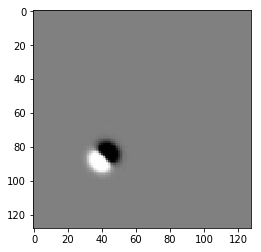

In [711]:
plt.imshow(a, cmap='gray')

In [712]:
# import time
# start_time = time.time()
# for i, d in enumerate(My_Train):
#     elapsed_time = time.time() - start_time
#     print(i, elapsed_time)
#     if i > 10:
#         break

In [713]:
# import time
# start_time = time.time()
# for i, d in enumerate(Train_Data):
#     elapsed_time = time.time() - start_time
#     print(i, elapsed_time)
#     if i > 10:
#         break

In [719]:
len(My_Test)

490

In [722]:
len(Test_Data.dataset)/16

30.625

In [714]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for _ in range(50 - len(Analyser.epoch_loss)):
    print('Version %d' % version)
    # for g in exp_lr_scheduler.optimizer.param_groups:
    """
    Here we can access Analyser.validation_loss to make decisions
    """
    # Learning rate scheduler
    # perform scheduler step if independent from validation loss
    if lrschedule == 'step':
        exp_lr_scheduler.step()
    train(len(Analyser.epoch_loss) + 1, Train_Data, Validate_Data, plot=False, channels=channels)
    # perform scheduler step if Dependent on validation loss
    if lrschedule == 'plateau':
        exp_lr_scheduler.step(Analyser.validation_loss[-1])
    save_network(model, maindir1 + Type_Network + "_Project_v%03d" % version)
    torch.save(model, maindir1 + Type_Network + "_Project_v%03d.pt" % version)
    save(Analyser, maindir1 + Type_Network + "_Analyser_v%03d" % version)
    scheduler_dict = {"Type": lrschedule, "Scheduler": exp_lr_scheduler}
    save(scheduler_dict, maindir1 + Type_Network + "_lrScheduler_v%03d" % version)
test(Test_Data, plot=False)
Analyser = []
model =[]
exp_lr_scheduler = []
scheduler_dict = []

Version 10
Training Epoch: 1
Ready to load batches
Batch: 0 loaded in 16.582
Starting t0: 57
Forward time: 19.744
Backward time: 9.419
Starting t0: 52
Forward time: 2.866
Backward time: 8.140
Starting t0: 14
Forward time: 2.948
Backward time: 7.714
Starting t0: 66
Forward time: 3.057
Backward time: 8.049
Starting t0: 29
Forward time: 2.818
Backward time: 7.846
Starting t0: 10
Forward time: 2.881
Backward time: 7.633
Starting t0: 21
Forward time: 2.830
Backward time: 7.834
Starting t0: 51
Forward time: 2.889
Backward time: 8.020
Starting t0: 4
Forward time: 2.745
Backward time: 7.378
Starting t0: 2
Forward time: 2.831
Backward time: 7.393
Train Epoch: 1 [1/144 (1%)]	Loss: 0.500753
Batch: 1 loaded in 0.002
Starting t0: 47
Forward time: 3.427


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/stathis/anaconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/stathis/anaco

KeyboardInterrupt: 